# Calibrated Explanations under the hood

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2024 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [Pima Indians Diabetes Database [kaggle]](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
2. ["Calibrated Explanations: with Uncertainty Information and Counterfactuals"](https://arxiv.org/abs/2305.02305) by [Helena Löfström](https://github.com/Moffran), [Tuwe Löfström](https://github.com/tuvelofstrom), Ulf Johansson, and Cecilia Sönströd.

The purpose of this demo is to show how to access information about the calibrated prediction, uncertainty, and feature rules. The first part loads data, trains a model and creates a calibrated factual explanation.

## Binary Classification
### Initialization

In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.5.1


In [3]:
# Load and preprocess the data
num_to_test = 10 # number of instances to test, one from each class
dataSet = 'diabetes_full'
delimiter = ','
model = 'RF'

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)


In [4]:
# Train the model and create the explainer
model = RandomForestClassifier()

model.fit(X_prop_train,y_prop_train)  

ce = CalibratedExplainer(model, 
                        X_cal, 
                        y_cal,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        class_labels={0:'Non-diabetic',1:'Diabetic'})

### Epistemic and Aletoric Uncertainty 
First, lets print the calibrated probabilities with corresponding uncertainty estimates. The information about the prediction can be found in the `prediction` dictionary in each explanation object. It always contain a `predict` field, with the calibrated probability  (classification and probabilistic regression) or prediction (regression), as well as a lower (`low`) and upper (`high`) bound for the value in `predict`. For classification, an additional `classes` field is also available, containing the class for which the probability is calculated for. For binary classification, it is always the positive class, whereas for multi-class, it is the class with highest calibrated probability.

The `predict` value (for classification and probabilistic regression) correspond to the epistemic uncertainty, and the uncertainty interval defined by the lower and upper bound correspond to the aletoric uncertainty.

In [5]:
factual_explanations = ce.explain_factual(X_test)
print('Probability [lower and upper bound] for Diabetic:')
print(*zip([f"Instance {i}: {exp.prediction['predict']:.3f} [{exp.prediction['low']:5.3f}, {exp.prediction['high']:5.3f}]" \
    for i, exp in enumerate(factual_explanations)]), sep='\n')

Probability [lower and upper bound] for Diabetic:
('Instance 0: 0.339 [0.304, 0.357]',)
('Instance 1: 0.533 [0.500, 0.571]',)
('Instance 2: 0.415 [0.404, 0.423]',)
('Instance 3: 0.050 [0.034, 0.051]',)
('Instance 4: 0.533 [0.500, 0.571]',)
('Instance 5: 0.388 [0.333, 0.423]',)
('Instance 6: 0.415 [0.404, 0.423]',)
('Instance 7: 0.614 [0.556, 0.708]',)
('Instance 8: 0.737 [0.722, 0.778]',)
('Instance 9: 0.219 [0.194, 0.226]',)


c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


### Factual Explanation
A _factual explanation_ is composed of a _calibrated prediction_ from the underlying model accompanied by an _uncertainty interval_ and a collection of _factual feature rules_, each composed of a _feature weight with an uncertainty interval_ and a _factual condition_, covering that feature's instance value. 

To access the information used for a feature rule, the easiest way is to use the `_get_rules()` method, gathering all information in a dictionary. The information composing _factual feature rules_ can be gathered from the fields `weight`, `weight_low`, `weight_high` and `rule`. The information shown below is the same as is plotted using `plot(uncertainty=True)`, with the difference that the rules in the plot are sorted on absolute feature weight.

Calibrated prediction with uncertainty interval:
0.339 [0.304, 0.357]

Instance value and factual feature rules, each composed of a factual condition and a feature weight with an uncertainty interval:
13.0  : Pregnancies > 6.50                        0.120 [ 0.113,  0.146]
145.0 : Glucose > 139.50                          0.149 [ 0.133,  0.226]
82.0  : BloodPressure > 81.00                    -0.051 [-0.062, -0.031]
19.0  : SkinThickness <= 23.50                   -0.009 [-0.034,  0.036]
110.0 : Insulin > 108.00                          0.083 [ 0.065,  0.131]
22.2  : BMI <= 27.85                             -0.076 [-0.084, -0.065]
0.24  : DiabetesPedigreeFunction <= 0.64         -0.048 [-0.079,  0.003]
57.0  : Age > 28.50                               0.005 [-0.012,  0.038]


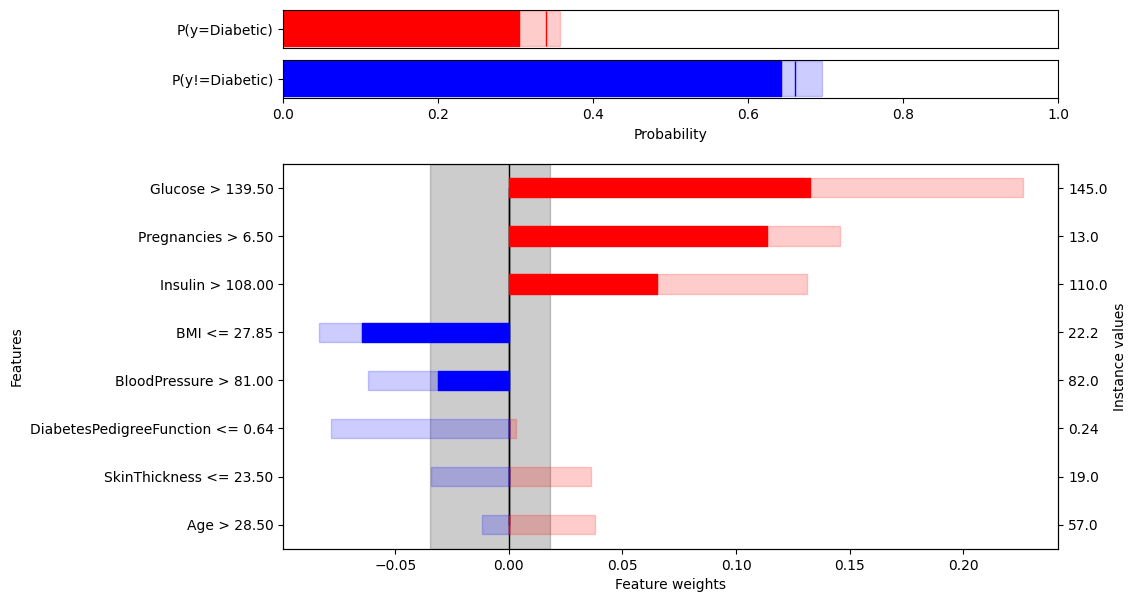

In [6]:
factual_explanation = factual_explanations.get_explanation(0)
factual = factual_explanation._get_rules()

print("Calibrated prediction with uncertainty interval:")
print(f"{factual['base_predict'][0]:5.3f} [{factual['base_predict_low'][0]:5.3f}, {factual['base_predict_high'][0]:5.3f}]")

print("\nInstance value and factual feature rules, each composed of a factual condition and a feature weight with an uncertainty interval:") 
for f, rule in enumerate(factual['rule']):
    print(f"{factual['value'][f]:6}: {rule:40s} {factual['weight'][f]:>6.3f} [{factual['weight_low'][f]:>6.3f}, {factual['weight_high'][f]:>6.3f}]")

factual_explanation.plot(uncertainty=True)

### Counterfactual Explanations
_Counterfactual explanations_ contain a collection of _alternative feature rules_, each composed of a _prediction estimate with an uncertainty interval_ and a _alternative condition_, covering alternative instance values for the feature.

In [7]:
alternative_explanations = ce.explore_alternatives(X_test)
alternative_explanation = alternative_explanations.get_explanation(0)
alternative = alternative_explanation._get_rules()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


For the alternative explanations, the probability for the positive class (or the class in the `classes` field in `prediction` for multi-class prediction) with uncertainty interval can be accessed for each alternative feature rule. The information showed below is the same as the `plot()` method, except that the alternative feature rules are sorted on their absolute feature weight. 

Calibrated prediction with uncertainty interval:
0.339 [0.304, 0.357]

Instance value and factual condition with probability and uncertainty interval:
13.0  : Pregnancies < 10.50                       0.246 [ 0.203,  0.262]
145.0 : Glucose < 139.50                          0.190 [ 0.113,  0.207]
145.0 : Glucose > 164.00                          0.415 [ 0.404,  0.423]
82.0  : BloodPressure < 81.00                     0.390 [ 0.371,  0.401]
82.0  : BloodPressure > 99.00                     0.388 [ 0.333,  0.423]
19.0  : SkinThickness < 12.50                     0.332 [ 0.300,  0.348]
19.0  : SkinThickness > 23.50                     0.348 [ 0.303,  0.373]
110.0 : Insulin < 108.00                          0.256 [ 0.208,  0.274]
110.0 : Insulin > 126.50                          0.415 [ 0.404,  0.423]
22.2  : BMI > 22.70                               0.463 [ 0.450,  0.475]
0.24  : DiabetesPedigreeFunction > 0.38           0.362 [ 0.304,  0.396]
57.0  : Age < 29.50                           

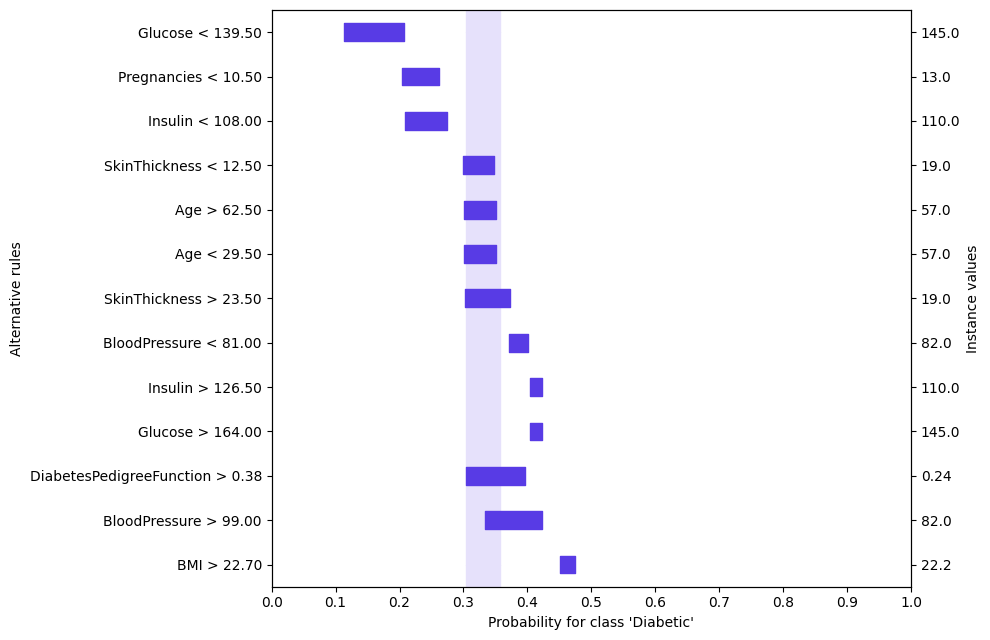

In [8]:
print("Calibrated prediction with uncertainty interval:")
print(f"{alternative['base_predict'][0]:5.3f} [{alternative['base_predict_low'][0]:5.3f}, {alternative['base_predict_high'][0]:5.3f}]")

print("\nInstance value and factual condition with probability and uncertainty interval:") 
for f, rule in enumerate(alternative['rule']):
    print(f"{alternative['value'][f]:6}: {rule:40s} {alternative['predict'][f]:>6.3f} [{alternative['predict_low'][f]:>6.3f}, {alternative['predict_high'][f]:>6.3f}]")

alternative_explanation.plot()

### Conjunctive Rules
Conjunctive factual rules can be handled the same way as simple rules.

Calibrated prediction with uncertainty interval:
0.339 [0.304, 0.357]

Conjunctive rules with feature weights and uncertainty intervals:
Pregnancies > 6.50                                            0.120 [ 0.113,  0.146]
Glucose > 139.50                                              0.149 [ 0.133,  0.226]
BloodPressure > 81.00                                        -0.051 [-0.062, -0.031]
SkinThickness <= 23.50                                       -0.009 [-0.034,  0.036]
Insulin > 108.00                                              0.083 [ 0.065,  0.131]
BMI <= 27.85                                                 -0.076 [-0.084, -0.065]
DiabetesPedigreeFunction <= 0.64                             -0.048 [-0.079,  0.003]
Age > 28.50                                                   0.005 [-0.012,  0.038]
Pregnancies > 6.50 & BloodPressure > 81.00                   -0.088 [-0.136, -0.071]
Pregnancies > 6.50 & BMI <= 27.85                             0.160 [ 0.139,  0.185]
Pregnancies >

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\explanations.py:916: UserWarning: Factual explanations for classification recommend using the binaryEntropy discretizer. Consider extracting factual explanations using `explainer.explain_factual(test_set)`
  warnings.warn('Factual explanations for classification recommend using the ' +\


Prediction [ Low ,  High]
0.339 [0.304, 0.357]
Value : Feature                                  Weight [ Low  ,  High ]
145.0 : Glucose > 139.50                          0.149 [ 0.133,  0.226]
13.0  : Pregnancies > 6.50                        0.120 [ 0.113,  0.146]
110.0 : Insulin > 108.00                          0.083 [ 0.065,  0.131]
22.2  : BMI <= 27.85                             -0.076 [-0.084, -0.065]
82.0  : BloodPressure > 81.00                    -0.051 [-0.062, -0.031]
0.24  : DiabetesPedigreeFunction <= 0.64         -0.048 [-0.079,  0.003]
19.0  : SkinThickness <= 23.50                   -0.009 [-0.034,  0.036]
57.0  : Age > 28.50                               0.005 [-0.012,  0.038]

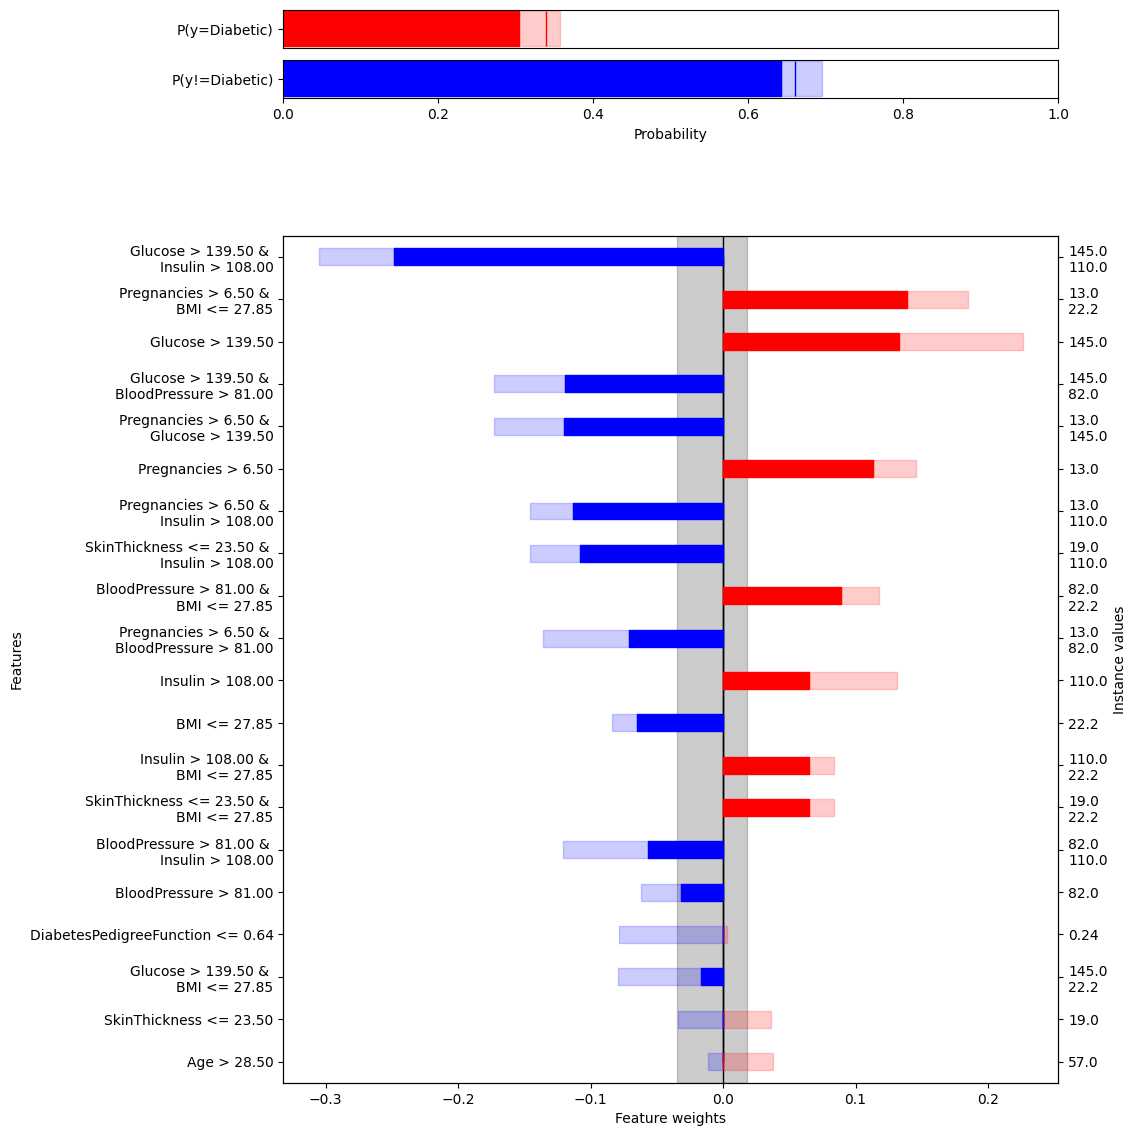

In [9]:
factual_explanation.add_conjunctions() 
conjunctive = factual_explanation._get_rules()

print("Calibrated prediction with uncertainty interval:")
print(f"{conjunctive['base_predict'][0]:5.3f} [{conjunctive['base_predict_low'][0]:5.3f}, {conjunctive['base_predict_high'][0]:5.3f}]")

print("\nConjunctive rules with feature weights and uncertainty intervals:")
for f, rule in enumerate(conjunctive['rule']):
    rule = rule.replace('\n', '')
    print(f"{rule:60s} {conjunctive['weight'][f]:>6.3f} [{conjunctive['weight_low'][f]:>6.3f}, {conjunctive['weight_high'][f]:>6.3f}]")
    
factual_explanation.plot(uncertainty=True)
factual_explanation.remove_conjunctions()

The same goes for alternative conjunctions.

Calibrated prediction with uncertainty interval:
0.339 [0.304, 0.357]

Conjunctive rules with feature weights and uncertainty intervals:
Pregnancies < 10.50                                           0.246 [ 0.203,  0.262]
Glucose < 139.50                                              0.190 [ 0.113,  0.207]
Glucose > 164.00                                              0.415 [ 0.404,  0.423]
BloodPressure < 81.00                                         0.390 [ 0.371,  0.401]
BloodPressure > 99.00                                         0.388 [ 0.333,  0.423]
SkinThickness < 12.50                                         0.332 [ 0.300,  0.348]
SkinThickness > 23.50                                         0.348 [ 0.303,  0.373]
Insulin < 108.00                                              0.256 [ 0.208,  0.274]
Insulin > 126.50                                              0.415 [ 0.404,  0.423]
BMI > 22.70                                                   0.463 [ 0.450,  0.475]
DiabetesPedig

Prediction [ Low ,  High]
0.339 [0.304, 0.357]
Value : Feature                                  Prediction [ Low  ,  High ]
145.0 : Glucose < 139.50                          0.190     [ 0.113,  0.207]
22.2  : BMI > 22.70                               0.463     [ 0.450,  0.475]
13.0  : Pregnancies < 10.50                       0.246     [ 0.203,  0.262]
110.0 : Insulin < 108.00                          0.256     [ 0.208,  0.274]
110.0 : Insulin > 126.50                          0.415     [ 0.404,  0.423]
145.0 : Glucose > 164.00                          0.415     [ 0.404,  0.423]
82.0  : BloodPressure < 81.00                     0.390     [ 0.371,  0.401]
82.0  : BloodPressure > 99.00                     0.388     [ 0.333,  0.423]
0.24  : DiabetesPedigreeFunction > 0.38           0.362     [ 0.304,  0.396]
19.0  : SkinThickness > 23.50                     0.348     [ 0.303,  0.373]
19.0  : SkinThickness < 12.50                     0.332     [ 0.300,  0.348]
57.0  : Age > 62.50          

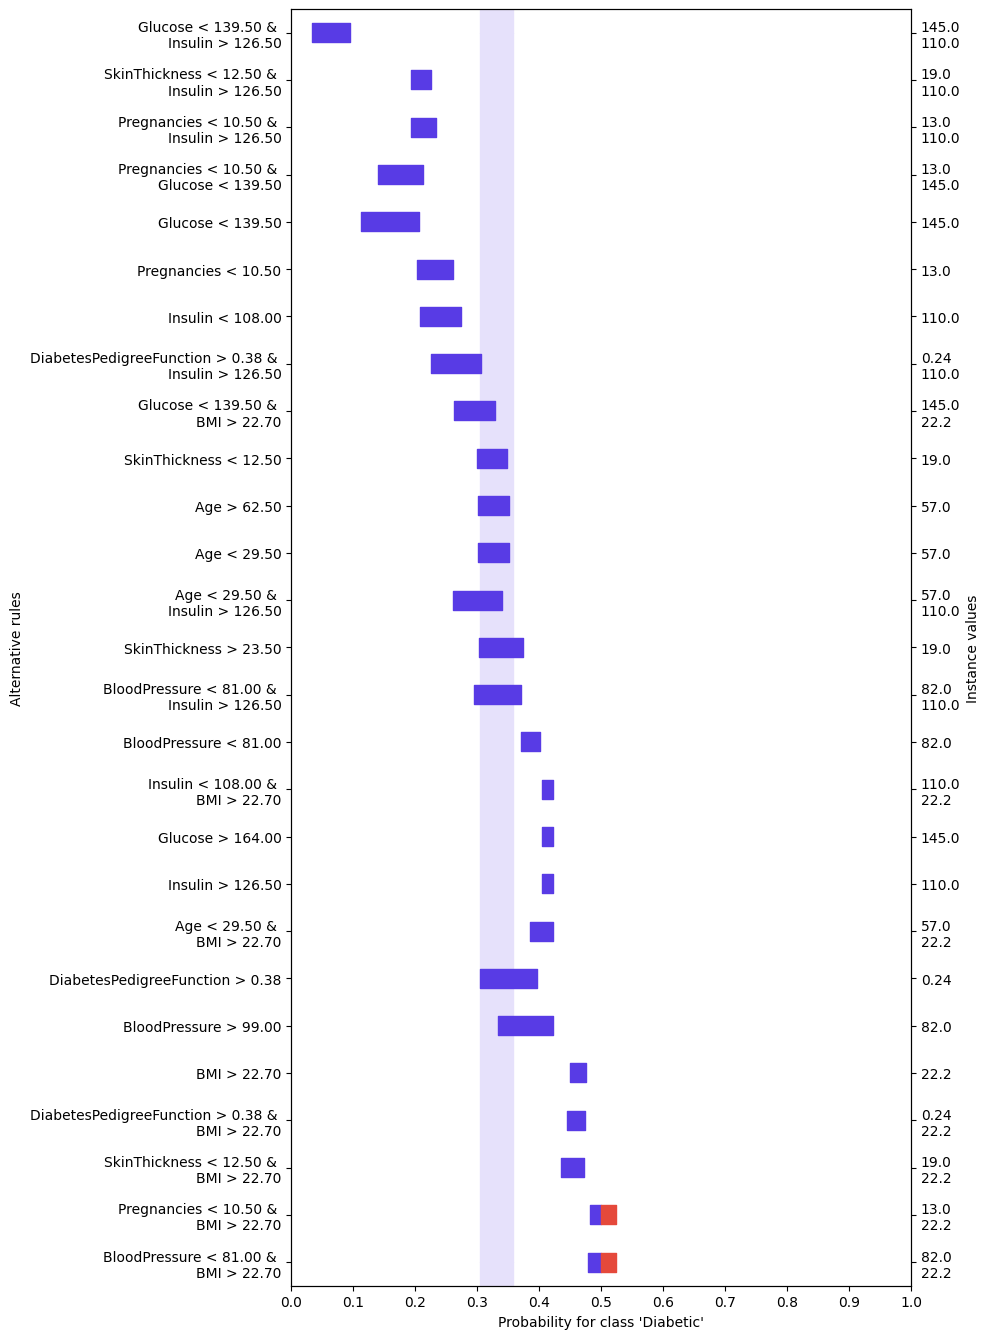

In [10]:
alternative_explanation.add_conjunctions() 
conjunctive = alternative_explanation._get_rules()

print("Calibrated prediction with uncertainty interval:")
print(f"{conjunctive['base_predict'][0]:5.3f} [{conjunctive['base_predict_low'][0]:5.3f}, {conjunctive['base_predict_high'][0]:5.3f}]")

print("\nConjunctive rules with feature weights and uncertainty intervals:")
for f, rule in enumerate(conjunctive['rule']):
    rule = rule.replace('\n', ' ')
    print(f"{rule:60s} {conjunctive['predict'][f]:>6.3f} [{conjunctive['predict_low'][f]:>6.3f}, {conjunctive['predict_high'][f]:>6.3f}]")
    
alternative_explanation.plot()
alternative_explanation.remove_conjunctions()